# Лабораторная работа №6
Реализовать метод Якоби поиска всех собственных чисел. Использовать две какие-либо стратегии выбора обнуляемого элемента.
- Вычисления проводить до достижения точности ε.
- Варьируя ε, скажем, от $10^{−2}$ до $10^{−5}$, изучить зависимость количества итераций от ε.
- Обязательно протестировать на матрице Гильберта порядка > 5.
- Выводить количество итераций. По теореме Гершгорина определить область, в которую должны попадать с.ч. матрицы.\
  Проверить, действительно ли найденные значения в область попали.

In [12]:
import seaborn as sns
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from scipy.linalg import hilbert
import unittest
from parameterized import parameterized, parameterized_class
from tabulate import tabulate
import numpy.testing

def run_test(TestCase):
    test_runner = unittest.TextTestRunner(verbosity=2)
    test_runner.run(unittest.makeSuite(TestCase))

## Метод Якоби

In [13]:
def gershgorin(A):
    N = A.shape[0]
    m = min(A[k, k] - sum(abs(A[k, j]) if k != j else 0 for j in range(N)) for k in range(N))
    M = max(A[k, k] + sum(abs(A[k, j]) if k != j else 0 for j in range(N)) for k in range(N))
    return m, M

# Максимальный недиагональный элемент
def max_element(A):
    N = A.shape[0]
    i_max, j_max = 0, 1
    for i in range(N):
        for j in range(i + 1, N):
            if i == j: continue
            if abs(A[i_max, j_max]) < abs(A[i, j]):
                i_max, j_max = i, j
    return i_max, j_max

# Нумеруем недиагональные элементы и обнуляем по кругу
def loop(A):
    N = A.shape[0]
    if loop.j + 1 == N:
        if loop.i + 2 == N:
            loop.i = 0
            loop.j = 1
        else:
            loop.i += 1
            loop.j = loop.i + 1
    else:
        loop.j += 1
    return loop.i, loop.j

def rotate(A, i, j):
    N = A.shape[0]
    x = -2 * A[i, j]
    y = A[i, i] - A[j, j]
    T = np.identity(N)

    phi = math.atan(2 * A[i, j] / (A[i, i] - A[j, j])) / 2
    c = math.cos(phi)
    s = math.sin(phi)
    T[i, i] = T[j, j] = c
    T[j, i] = s
    T[i, j] = -s

    return T.T @ A @ T

def jacobi(A, eps, strategy):
    if not numpy.allclose(A, A.T):
        raise ValueError('Матрица должна быть симметричной')

    strat_map = {'max': max_element, 'loop': loop}
    N = A.shape[0]

    strategy_func = strat_map[strategy]

    if strategy == 'loop':
        loop.i = 0
        loop.j = 0

    iterations = 0
    while True:
        iterations += 1
        i, j = strategy_func(A)

        if np.abs(A[i, j]) < eps:
            return np.diagonal(A).copy(), iterations
        A = rotate(A, i, j)


### Тесты для метода Якоби

In [14]:
def test_name(testcase_func, param_num, param):
    size = str(param.args[0])
    eps = str(param.args[1])
    return "%s_%s" %(
        testcase_func.__name__,
        parameterized.to_safe_name(f'_{size}x{size}_eps={eps}')
    )

def gen_symmetric(N):
    a = np.random.rand(N, N)
    return np.tril(a) + np.tril(a, -1).T

def test_jacobi(size, eps, strategy, prints=True, asserts=False, gen=gen_symmetric):
    A = gen(size)
    expected = np.linalg.eigvalsh(A)
    actual, rotations = jacobi(A, eps, strategy)
    expected.sort()
    actual.sort()

    # проверяем, попадают ли собственные числа в объединение кругов Гершгорина
    m, M = gershgorin(A)
    assert(all(m <= eigv and eigv <= M for eigv in actual))

    if prints:
        table = {'Метод Якоби': actual, 'Встроенная функция numpy': expected}
        print(f'Матрица {size}x{size}, eps={eps}, strategy={strategy}')
        print(tabulate(table, headers='keys', tablefmt='psql'))
    if asserts:
        np.testing.assert_allclose(expected, actual, rtol=eps)

class JacobiTestCase(unittest.TestCase):
    @parameterized.expand([(i, 10 ** -eps) for i, eps in product(range(2, 8), range(2, 6))], name_func=test_name)
    def test_jacobi_max(self, size, eps):
        test_jacobi(size, eps, 'max', False, True)

    #@parameterized.expand([(i, 10 ** -eps) for i, eps in product(range(2, 8), range(2, 6))], name_func=test_name)
    #def test_jacobi_loop(self, size, eps):
    #    test_jacobi(size, eps, 'loop', False, True)


run_test(JacobiTestCase)

test_jacobi_max__2x2_eps_0_0001 (__main__.JacobiTestCase) ... ok
test_jacobi_max__2x2_eps_0_001 (__main__.JacobiTestCase) ... ok
test_jacobi_max__2x2_eps_0_01 (__main__.JacobiTestCase) ... ok
test_jacobi_max__2x2_eps_1e_05 (__main__.JacobiTestCase) ... ok
test_jacobi_max__3x3_eps_0_0001 (__main__.JacobiTestCase) ... ok
test_jacobi_max__3x3_eps_0_001 (__main__.JacobiTestCase) ... ok
test_jacobi_max__3x3_eps_0_01 (__main__.JacobiTestCase) ... ok
test_jacobi_max__3x3_eps_1e_05 (__main__.JacobiTestCase) ... ok
test_jacobi_max__4x4_eps_0_0001 (__main__.JacobiTestCase) ... ok
test_jacobi_max__4x4_eps_0_001 (__main__.JacobiTestCase) ... ok
test_jacobi_max__4x4_eps_0_01 (__main__.JacobiTestCase) ... ok
test_jacobi_max__4x4_eps_1e_05 (__main__.JacobiTestCase) ... ok
test_jacobi_max__5x5_eps_0_0001 (__main__.JacobiTestCase) ... ok
test_jacobi_max__5x5_eps_0_001 (__main__.JacobiTestCase) ... ok
test_jacobi_max__5x5_eps_0_01 (__main__.JacobiTestCase) ... ok
test_jacobi_max__5x5_eps_1e_05 (__main__

## Зависимость количества итераций от $\epsilon$

In [15]:
plt.style.use('default')
sns.color_palette('bright')

def plot(data, title, xticks):
    df = pd.DataFrame(data, index=xticks)

    plt.figure(figsize=(15, 10), dpi=80)

    for key in df.keys():
        plt.plot(df[key], label=key, marker='o')

    plt.title(title)
    plt.legend(title='Размерность матрицы')
    plt.xlabel('Епсилон', fontsize=20)
    plt.ylabel('Количество итераций', fontsize=20)
    plt.xscale('log')
    plt.show()

In [16]:
def get_data(gen, strategy):
    data = {}
    for size in range(2, 12):
        key = f'{size}x{size}'
        data[key] = []
        A = gen(size)

        for eps in np.logspace(-2, -6, num=5):
            actual, k = jacobi(A, eps, strategy)
            data[key].append(k)
    return data

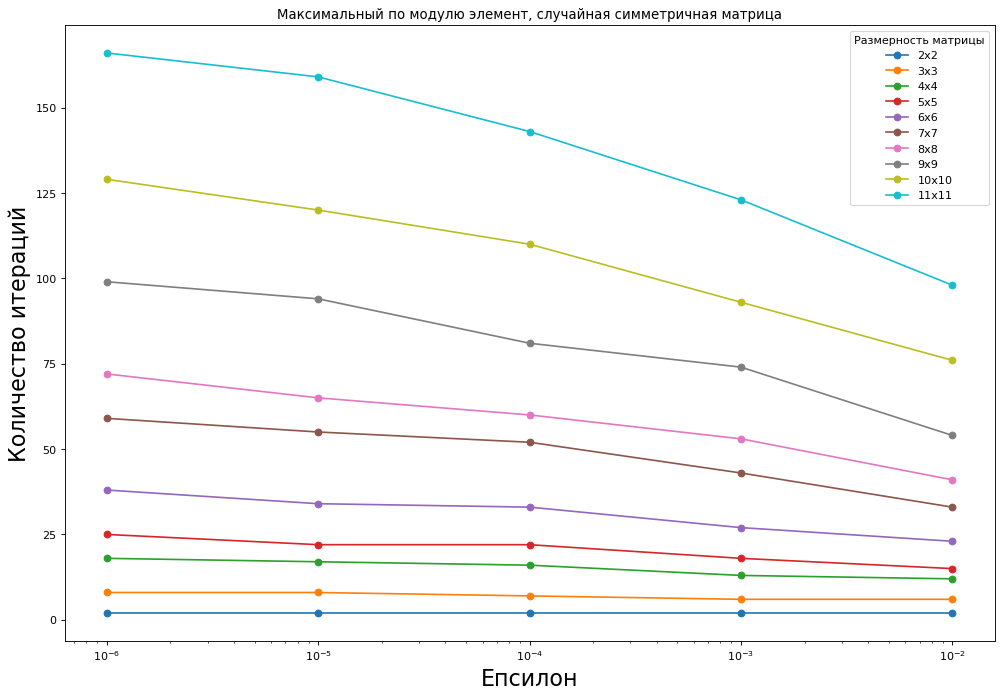

In [17]:
plot(get_data(gen_symmetric, 'max'), 'Максимальный по модулю элемент, случайная симметричная матрица', np.logspace(-2, -6, num=5))

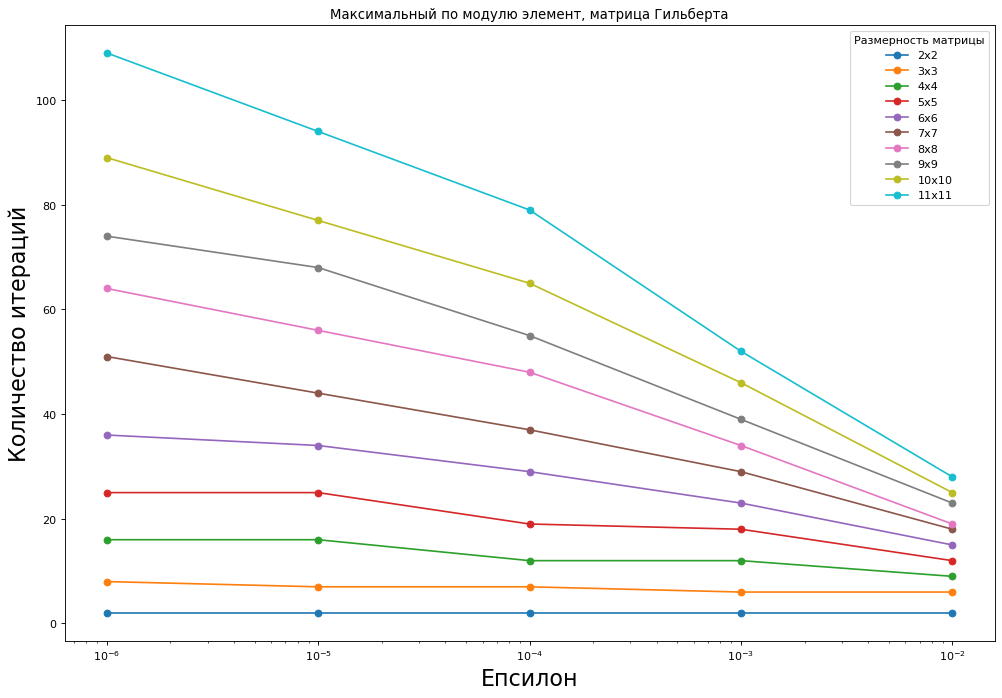

In [18]:
plot(get_data(hilbert, 'max'), 'Максимальный по модулю элемент, матрица Гильберта', np.logspace(-2, -6, num=5))

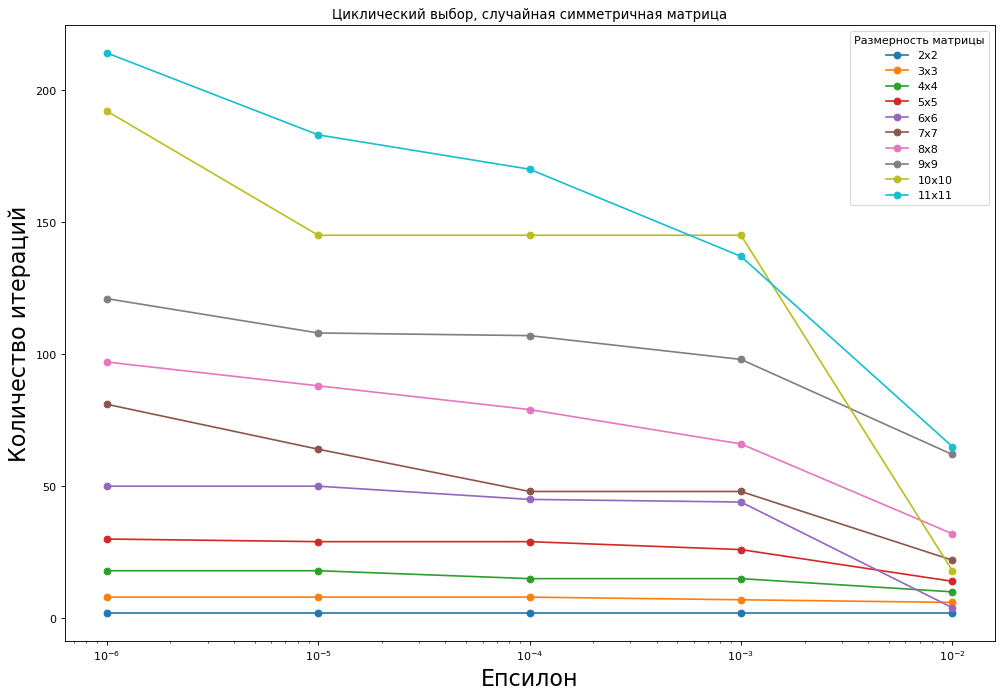

In [19]:
plot(get_data(gen_symmetric, 'loop'), 'Циклический выбор, случайная симметричная матрица', np.logspace(-2, -6, num=5))

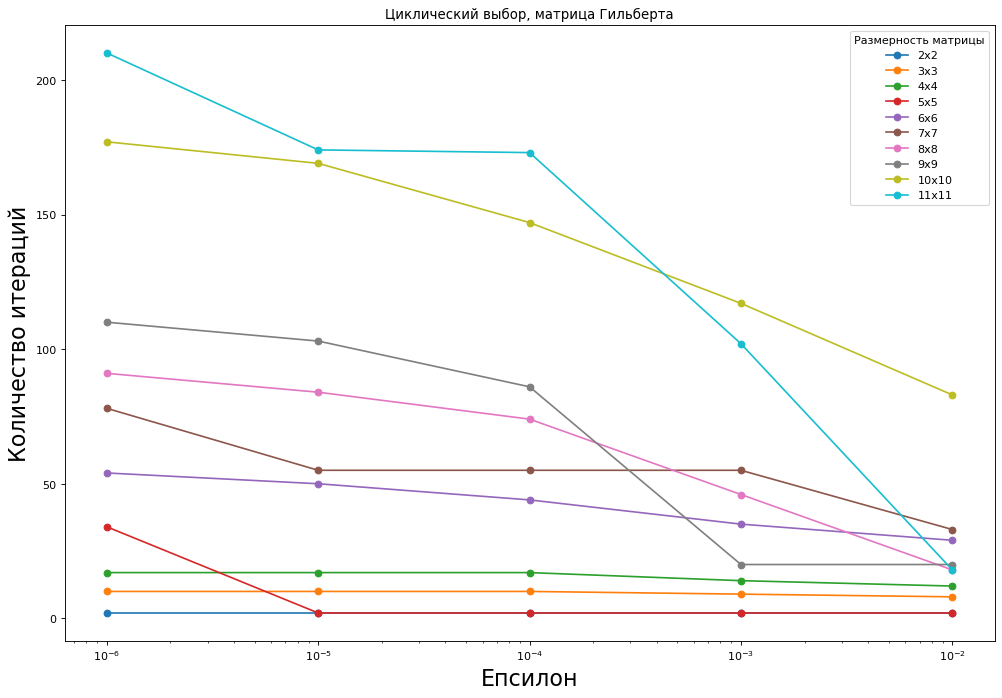

In [20]:
plot(get_data(gen_symmetric, 'loop'), 'Циклический выбор, матрица Гильберта', np.logspace(-2, -6, num=5))